# Trabalho de Algebra Linear e Computacional

# Introdução

   Este trabalho tem como objetivos, mostrar a implementação de 3 métodos de decomposição de matrizes,   
    1. Gram-Schmidt
    2. Rotação de Givens
    3. Householder
    
   bem como mostrar gráficos e testes demonstrando tempo de execução,vantagens e desvantagens de cada metodo, e modelos de regressão com e sem 
    log-scale para cada metodo já citado.

In [1]:
import numpy as np
import pandas as pd
import itertools as it
import math
from scipy.linalg import lu
from scipy.linalg import lstsq
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time
plt.style.use('seaborn-whitegrid')

# Gram-Schmidt
   Este método obtém uma base ortonormalizada a partir de uma base qualquer, ou seja, transforma um conjunto de vetores linearmente independentes(LI) em um conjunto ortogonal que gera o mesmo espaço vetorial.
   
   O processo de Gram-Schmidt encontra uma projeção ortogonal $q_n$ para cada vetor de coluna $a_n$ e subtraindo suas projeções para as projeções anteriores. O vetor resultante é então dividido pelo comprimento desse vetor para produzir um vetor unitário.
   
   Vamos considerar A uma matriz com n vetores-coluna
   
   $$A = \left[ a_1 | a_2 | \cdots | a_n \right]$$
   
   Primeiro vamos encontrar a projeção ortogonal de $a_1$
   
   $$v_1 = a_1, \qquad e_1 = \frac{v_1}{||v_1||}$$
   
   Para o passo seguinte e os demais, devemos subtrair as projeções anteriores: 
   
   $$v_2 = a_2 - proj_{v_1} (a_2) = a_2 - (a_2 \cdot e_1) e_1, \qquad e_2 = \frac{v_2}{||v_2||}$$
         
   $$v_{k+1} = a_{k+1} - (a_{k+1} \cdot e_{1}) e_1 - \cdots - (a_{k+1} \cdot e_k) e_k, \qquad e_{k+1} = \frac{u_{k+1}}{||u_{k+1}||}$$
   
   No fim, a matriz $A$ pode ser fatorada da seguinte forma 

$$A = \left[a_1 | a_2 | \cdots | a_n \right] = \left[e_1 | e_2 | \cdots | e_n \right] \begin{bmatrix}a_1 \cdot e_1 & a_2 \cdot e_1 & \cdots & a_n \cdot e_1 \\ 0 & a_2 \cdot e_2 & \cdots & a_n \cdot e_2 \\ \vdots & \vdots & & \vdots \\ 0 & 0 & \cdots & a_n \cdot e_n\end{bmatrix} = QR$$
   Onde $Q$ é uma matriz ortonormal, ou seja $Q^T Q = I$ onde $I$ é a matriz identidade, e $R$ é uma matriz triangular superior.

In [2]:
#Gera uma matriz LI
def matrizLI(m,n):
    A = np.random.randint(0,5,(m,n))
    p,l,u = lu(A)                         #Faz a decomposicao LU dela
    delj,deli = [],[]
    
    sup_indices = np.triu_indices(n)      #Retorna uma lista com os 'i's e outra lista com os 'j's da parte superior
    
    for i,j in zip(sup_indices[0],sup_indices[1]):
        if i!=j and u[i][j]==0:       #Percorre a parte superior da matriz U e checa aonde existe 0 
            deli.append(i)           #Lista as linhas onde existe o 0
            delj.append(j)           #Lista as colunas onde existe 0 pra deleta-las
               
    for i,j in it.product(deli,delj):
        A=np.delete(A,j,axis=1)           #Deleta as colunas listadas.
        e0=np.eye(m)[i]
        A=np.insert(A, j, e0, axis=1)     #Coloca o vetor ei(coluna i da identidade) no lugar do vetor que deixava LD
    
    return A



In [3]:
def gram_schmidt(A):
    # Criar matriz Q
    Q = np.zeros(A.shape)
    # Atualização dos vetores/colunas de    
    for i in range(A.shape[1]):
        # Vetor i de Q recebe o vetor i de A
        Q[:, i] = A[:, i]
        # Somatório das projeções dos vetores de A em Q
        for j in range(i):
            # formula para compor o q chapéu
            Q[:, i] -= Q[:, j].T @ A[:, i] * Q[:, j]
        # Normalização do vetor q
        #Q[:, i] /= np.linalg.norm(Q[:, i])
        # arredondamento, se divisao for muito pequena, aproximamos a 1, para reduzir erro numérico
        Q[:, i] /= np.linalg.norm(Q[:, i]) < 1e-8 and 1 or np.linalg.norm(Q[:, i])
        
    R = Q.T @ A
    return Q,R

Matriz A:
[[3 4 3 0 0]
 [2 2 4 4 1]
 [1 1 4 0 0]
 [2 0 4 2 0]
 [4 4 4 1 0]
 [3 2 3 1 0]
 [4 1 1 4 0]]

Matriz R:
[[ 7.6811  5.5981  7.551   4.5566  0.2604]
 [-0.      3.2651  1.4483 -2.2996  0.1661]
 [-0.      0.      4.8873  0.8028  0.3669]
 [-0.     -0.      0.      3.3622  0.8628]
 [ 0.      0.     -0.      0.      0.1598]]

Matriz Q:
[[ 0.3906  0.5554 -0.1542 -0.1126 -0.2518]
 [ 0.2604  0.1661  0.3669  0.8628  0.1598]
 [ 0.1302  0.0831  0.5927 -0.2612 -0.2494]
 [ 0.2604 -0.4464  0.5485 -0.1943 -0.1704]
 [ 0.5208  0.3322 -0.0846 -0.1609 -0.1309]
 [ 0.3906 -0.0571  0.0273 -0.2775  0.8585]
 [ 0.5208 -0.5866 -0.4261  0.1845 -0.2565]]

Q x R:
[[ 3.  4.  3.  0.  0.]
 [ 2.  2.  4.  4.  1.]
 [ 1.  1.  4. -0. -0.]
 [ 2.  0.  4.  2. -0.]
 [ 4.  4.  4.  1.  0.]
 [ 3.  2.  3.  1.  0.]
 [ 4.  1.  1.  4.  0.]]

Matriz A = Q x R??
 [[ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [

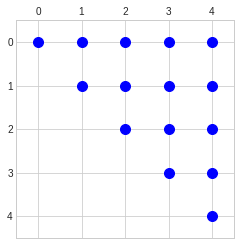

In [4]:
m, n = 7,5

A = matrizLI(m,n)
Q,R = gram_schmidt(A)
R = R.round(4)

print("Matriz A:\n{}\n\nMatriz R:\n{}\n\nMatriz Q:\n{}\n\nQ x R:\n{}".format(A, R, Q.round(4), (Q@R).round(4)))
print("\nMatriz A = Q x R??\n", (A.round(3)==(Q@R).round(3)))

plt.spy(R,marker='o',c='b')

# Rotação de Givens
   A decomposição $QR$ também pode ser feita usando Rotação de Givens, onde cada rotação zera um elemento da subdiagonal da matriz $A$, formando uma matriz $R$, e a matriz $Q$ ortogonal formada pela multiplicação de todas as matrizes $G$.
   
   Seja $A$ 
   $$\begin{bmatrix}
       12 & -51 & 4\\
       6 & 167 & -68\\
       -4 & 24 & -41 
      \end{bmatrix}$$
   Vamos zerar o elemento mais a esquerda e abaixo $a_{31}$ = 4, isso é feito usando o metodo de rotação de givens e vamos chamar de $G_1$ primeiro o vetor $\begin{bmatrix}
       12 & -4
      \end{bmatrix}$ será rotacionado para que aponte para a mesma direção do eixo $x$, este vetor forma um ângulo$\theta$= $\arctan(4/12)$ deste modo é criada a $G_1$ $$\begin{bmatrix}
       cos(\theta) & 0 & -sen(\theta)\\
       0 & 1 & 0\\
       sen(\theta) & 0 & cos(\theta) 
      \end{bmatrix}$$ $G_1A$ $$\begin{bmatrix}0.94868 & 0 & -0.31622\\0 & 1 & 0\\0.31622 & 0 & 0.94868\end{bmatrix}\begin{bmatrix}
       12 & -51 & 4\\
       6 & 167 & -68\\
       -4 & 24 & -41 
      \end{bmatrix}$$      
      $$G_1A=\begin{bmatrix}
       12.64911 & -55.97231 & 16.76007\\
       6 & 167 & -68\\
       0 & 6.64078 & -37.6311\end{bmatrix}$$
   
   
   podemos obter de forma analoga matrizes $G_2$ e $G_3$ para zerar os elementos $a_{21}$ e $a_{32}$, formando assim uma matriz triangular $R$, e a matriz $Q^T$=$G_3G_2G_1$.
      
      

In [5]:
def entradas(a,b):
    # Calcula seno e coseno para entradas da matriz de rotação.
    hip = math.hypot(a,b)
    cos = a/hip
    sen = -b/hip
    return (cos,sen)

In [48]:
def rotacao_givens(A):
    qtd_linhas, qtd_colunas = A.shape
                                   
    Q = np.identity(A.shape[0])             # Inicializando a matriz ortogonal Q.
    R = np.copy(A)                          # Inicializando a matriz triangular superior R.
    
    # As iterações serão feitas sobre a matriz triangular inferior
    linhas, colunas = np.tril_indices(qtd_linhas, -1, qtd_colunas)
    #i = 0
    G = np.identity(qtd_linhas)
    for (linha, coluna) in zip(linhas, colunas):
        # As rotações são feitas para os valores da matriz triangular
        # inferior que são diferentes de zero.
        if(R[linha,coluna] != 0):
            cos, sen = entradas(R[coluna, coluna], R[linha,coluna])          
            G[coluna, coluna] = cos
            G[linha, linha] = cos
            G[linha, coluna] = sen
            G[coluna, linha] = -sen
            R = np.dot(G, R)
            Q = np.dot(Q,G.T)
            G[coluna, coluna] = 1
            G[linha, linha] = 1
            G[linha, coluna] = 0
            G[coluna, linha] = 0      
        #i = i+1
        #print("Matriz Q{}:\n{}\n\nMatriz R{}:\n{}\n".format(i, Q.round(5), i, R.round(5)))
    return (Q,R)

Matriz A:
[[4 4 3 2 3]
 [4 2 0 1 1]
 [0 1 1 0 4]
 [0 0 4 2 2]
 [4 0 0 2 0]
 [2 0 2 4 4]
 [0 1 3 4 1]]

Matriz R:
[[ 7.2111   3.3282   2.2188   3.8829   3.3282 ]
 [ 0.       3.30501  2.60677  0.32585  2.39729]
 [ 0.       0.       5.22319  4.69736  3.51628]
 [ 0.       0.       0.       2.78418  0.27962]
 [ 0.      -0.       0.      -0.       4.21113]
 [ 0.       0.       0.      -0.      -0.     ]
 [ 0.       0.       0.       0.       0.     ]]

Matriz Q:
[[ 0.5547  0.6517  0.0135 -0.1543 -0.098   0.3446 -0.3395]
 [ 0.5547  0.0465 -0.2589  0.0169 -0.0124 -0.7609  0.209 ]
 [ 0.      0.3026  0.0404 -0.1037  0.7507  0.1436  0.5585]
 [ 0.      0.      0.7658 -0.5737 -0.1264 -0.2513  0.0726]
 [ 0.5547 -0.5586  0.0431 -0.0627 -0.1523  0.4594  0.3745]
 [ 0.2774 -0.2793  0.4045  0.4002  0.5254 -0.0861 -0.4878]
 [ 0.      0.3026  0.4234  0.687  -0.3339  0.      0.3818]]

Inversa de Q:
[[ 0.5547  0.5547  0.     -0.      0.5547  0.2774 -0.    ]
 [ 0.6517  0.0465  0.3026  0.     -0.5586 -0.2793  

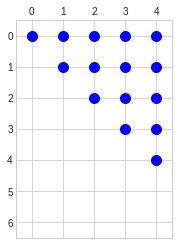

In [49]:
m, n = 7, 5
A = np.random.randint(0,5,(m,n))

Q, R = rotacao_givens(A)
R = R.round(5)

print("Matriz A:\n{}\n\nMatriz R:\n{}\n\nMatriz Q:\n{}\n\nInversa de Q:\n{}\n\nQ x R:\n{}".format(A, R, Q.round(4), np.linalg.inv(Q).round(4), (Q@R).round(4)))

print("\nMatriz A = Q x R??\n", (A.round(4)==(Q@R).round(4)))

plt.spy(R,marker='o',c='b')

# Householder
É a abordagem mais comum para a decomposição do $QR$ uma vez que utilizar Gram-Schmidt não é recomendado, pois pode levar ao cancelamento que causa imprecisão, o que pode resultar em uma matriz $Q$ não ortogonal. As reflexões de Householder são outro método de transformação ortogonal que transforma um vetor x em um vetor unitário y paralelo a x. A matriz de reflexão de Household com vetor normal v assume a forma:$$H = I - 2vv^T$$

como
$$u = \frac{v}{||v||}$$

temos a seguinte forma:
$$H(x) = I - 2vv^T = I - 2 \frac{uu^T}{u^Tu}$$

Este método de decomposição funciona encontrando matrizes $H$ apropriadas e multiplicando-as pela esquerda a matriz original $A$, para construir a matriz triangular superior $R$. Como vimos anteriormente, diferentemente do procedimento de Gram-Schmidt, a abordagem de reflexão de Household não forma explícita a matriz $Q$. No entanto, a matriz $Q$ pode ser encontrada utilizando o produto escalar de cada matriz Household formada sucessivamente.$$Q = H_1 H_2 \cdots H_{m-2}H_{m-1}$$

seja $A$ a seguinte matriz 
$$A = \begin{bmatrix}
  2 & - 2 & 18 \\
  2 & 1 & 0 \\
  1 & 2 & 0
\end{bmatrix}$$


$$v_1 = a_1 + sign(a_{11})||a_1||e_1$$

$$v_1 = \begin{bmatrix}2 \\ 2 \\ 1 \end{bmatrix} + \sqrt{\sum^m_{k=1}{a_1}^2} \begin{bmatrix}1 \\ 0 \\ 0 \end{bmatrix} = \begin{bmatrix} 5 \\ 2 \\ 1 \end{bmatrix}$$

A matriz $H_1$ $$H_1 = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix} - 2 \frac{\begin{bmatrix} 2 & 2 & 1 \end{bmatrix}\begin{bmatrix} 2 \\ 2 \\ 1 \end{bmatrix}}{\begin{bmatrix} 2 \\ 2 \\ 1 \end{bmatrix}\begin{bmatrix} 2 & 2 & 1 \end{bmatrix}} =$$
$$H_1 = \begin{bmatrix} -\frac{2}{3} & -\frac{2}{3} & -\frac{1}{3} \\ -\frac{2}{3} & 0.7333 & -0.1333 \\ -\frac{1}{3} & -0.1333 & 0.9333 \end{bmatrix}$$

com a matriz $H_1$ podemos obter $R$ fazendo $H_1A$

$$H_1 A = \begin{bmatrix} -\frac{2}{3} & -\frac{2}{3} & -\frac{1}{3} \\ -\frac{2}{3} & 0.7333 & -0.1333 \\ -\frac{1}{3} & -0.1333 & 0.9333 \end{bmatrix} \begin{bmatrix} 2 & - 2 & 18 \\ 2 & 1 & 0 \\ 1 & 2 & 0 \end{bmatrix}$$
$$H_1 A = \begin{bmatrix} -3 & 0 & -12 \\ 0 & 1.8 & 12 \\ 0 & 2.4 & -6 \end{bmatrix}$$

Na proxima iteração $A$ é substituida por $H_1A$ considere agora a submatriz

$$A^{(1)} = \begin{bmatrix} 1.8 & 12 \\ 2.4 & -6 \end{bmatrix}$$

$v_2$ é dado por $$\begin{bmatrix} 1.8 \\ 2.4 \end{bmatrix} + \sqrt{\sum^m_{j=1} a_2^2} \begin{bmatrix} 1 \\ 0 \end{bmatrix} = \begin{bmatrix} 4.8 \\ 2.4 \end{bmatrix}$$

$H_2$

$$H_2 = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} - 2 \frac{\begin{bmatrix} 4.8 & 2.4 \end{bmatrix} \begin{bmatrix} 4.8 \\ 2.4 \end{bmatrix}}{\begin{bmatrix} 4.8 \\ 2.4 \end{bmatrix} \begin{bmatrix} 4.8 & 2.4 \end{bmatrix}}$$

$$H_2 = \begin{bmatrix} 1 & 0 & 0 \\ 0 & -0.6 & -0.8 \\ 0 & -0.8 & 0.6 \end{bmatrix}$$

$H_2A$ $$\begin{bmatrix} 1 & 0 & 0 \\ 0 & -0.6 & -0.8 \\ 0 & -0.8 & 0.6 \end{bmatrix} \begin{bmatrix} -3 & 0 & -12 \\ 0 & 1.8 & 12 \\ 0 & 2.4 & -6 \end{bmatrix}$$

$$H_2 A = \begin{bmatrix} -3 & 0 & -12 \\ 0 & -3 & 12 \\ 0 & 0 & 6 \end{bmatrix}$$

$v_3$ é dado por $$\begin{bmatrix} 6 \end{bmatrix} -  \sqrt{\sum^m_{j=1} a_3^2} \begin{bmatrix} 1 \end{bmatrix} = 12$$

A ultima matriz $H$ a $H_3$ $$H_3 = \begin{bmatrix} 1 \end{bmatrix} - 2 \frac{\begin{bmatrix} 12 \end{bmatrix}\begin{bmatrix} 12 \end{bmatrix}}{\begin{bmatrix} 12 \end{bmatrix}\begin{bmatrix} 12 \end{bmatrix}} = \begin{bmatrix}1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & -1 \end{bmatrix}$$

$$H_3 A = \begin{bmatrix}1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & -1 \end{bmatrix} \begin{bmatrix} -3 & 0 & -12 \\ 0 & -3 & 12 \\ 0 & 0 & 6 \end{bmatrix}$$

$$H_3 A = R = \begin{bmatrix} -3 & 0 & -12 \\ 0 & -3 & 12 \\ 0 & 0 & -6 \end{bmatrix}$$

Como dito anteriormente a matriz $Q$ é encontrada
$$H_1 H_2 H_3 = Q$$ $$Q = \begin{bmatrix} -\frac{2}{3} & -\frac{2}{3} & -\frac{1}{3} \\ -\frac{2}{3} & 0.7333 & -0.1333 \\ -\frac{1}{3} & -0.1333 & 0.9333 \end{bmatrix} \begin{bmatrix} 1 & 0 & 0 \\ 0 & -0.6 & -0.8 \\ 0 & -0.8 & 0.6 \end{bmatrix} \begin{bmatrix}1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & -1 \end{bmatrix}$$ $$Q = \begin{bmatrix} -\frac{2}{3} & \frac{2}{3} & -\frac{1}{3} \\ -\frac{2}{3} & -\frac{1}{3} & \frac{2}{3} \\ -\frac{1}{3} & -\frac{2}{3} & -\frac{2}{3} \end{bmatrix}$$

O resultado obtido é o mesmo que obtido pelo Gram-Schmidt 
$$QR = \begin{bmatrix} -\frac{2}{3} & \frac{2}{3} & -\frac{1}{3} \\ -\frac{2}{3} & -\frac{1}{3} & \frac{2}{3} \\ -\frac{1}{3} & -\frac{2}{3} & -\frac{2}{3} \end{bmatrix} \begin{bmatrix} -3 & 0 & -12 \\ 0 & -3 & 12 \\ 0 & 0 & -6 \end{bmatrix}$$


In [8]:
def matriz_householder(v):
    #Gera a matriz de refleccao para o vetor v
    tam_v = v.shape[0]
        
    e1 = np.eye(tam_v)[0]                        #Primeira coluna da identidade                    
    vetor = np.linalg.norm(v) * e1               #Vetor [||v||,0....]
    
    if v[0] < 0:                                 #Se o primeiro elemento for < 0,troca o sinal
        vetor = - vetor
    u = v + vetor
    
    H = np.eye(tam_v) -  ((2 * np.outer(u,u)) / np.dot(u,np.transpose(u)))      #Gera H
    
    return H

In [9]:
def QR_householder(A):
    m,n = A.shape                                 
    Q = np.eye(m)
    R = A
    menor_dim = min(m,n)

    for i in range(menor_dim):
        v = R[i:, i]                               #linha it pra frente e coluna it
        Hh = matriz_householder(v)                 #Recebe a matriz de refleccao para o vetor v

        H = np.eye(m)                              #Identidade
        H[i:, i:] = Hh                             #Preenche com a matriz de refleccao as linhas e colunas i pra frente

        R = np.dot(H, R)                           #Gera R
        Q = np.dot(Q, H)                           #Gera Q
        
    return Q,R

Matriz A:
[[3 1 0 4 3]
 [1 4 4 1 3]
 [1 2 0 4 2]
 [2 3 2 3 0]
 [3 2 4 3 0]
 [1 4 4 2 1]
 [1 0 1 3 1]]

Matriz R:
[[-5.09902 -4.9029  -4.9029  -7.2563  -3.13786]
 [ 0.      -5.09525 -4.3102  -0.67182 -1.49461]
 [ 0.       0.       3.22238 -1.69831 -1.49786]
 [-0.       0.       0.       2.83029  0.59458]
 [-0.      -0.      -0.      -0.       3.05334]
 [-0.       0.      -0.      -0.       0.     ]
 [-0.      -0.      -0.       0.       0.     ]]

Matriz Q:
[[-0.5883  0.3699 -0.4004 -0.2476  0.4107  0.3559  0.0065]
 [-0.1961 -0.5963  0.1453 -0.2039  0.6    -0.379   0.1989]
 [-0.1961 -0.2038 -0.571   0.5195 -0.0276 -0.3535 -0.4454]
 [-0.3922 -0.2114 -0.2588 -0.1511 -0.6041 -0.1385  0.5723]
 [-0.5883  0.1736  0.5784 -0.0602 -0.2242 -0.2782 -0.3974]
 [-0.1961 -0.5963  0.1453  0.1495 -0.1238  0.7097 -0.2084]
 [-0.1961  0.1887  0.2644  0.7606  0.1999  0.0667  0.4829]]

Inversa de Q:
[[-0.5883 -0.1961 -0.1961 -0.3922 -0.5883 -0.1961 -0.1961]
 [ 0.3699 -0.5963 -0.2038 -0.2114  0.1736 -0.5963  

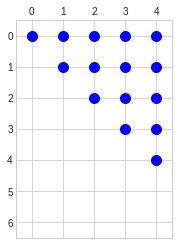

In [10]:
m,n = 7,5
A = np.random.randint(0,5,(m,n))

Q,R = QR_householder(A)

R = R.round(5)

print("Matriz A:\n{}\n\nMatriz R:\n{}\n\nMatriz Q:\n{}\n\nInversa de Q:\n{}\n\nQ x R:\n{}".format(A, R, Q.round(4), np.linalg.inv(Q).round(4), (Q@R).round(4)))
print("\nMatriz A = Q x R??\n", (A.round(4)==(Q@R).round(4)))

plt.spy(R,marker='o',c='b')

# Gráficos

In [11]:
def rodar(f,dim):
    #f: Método a ser rodado
    #dim: lista com as dimensoes das matrizes
    
    tempos = []
    temposGeracao = []
    flag = False
    
    if f.__name__ == 'gram_schmidt': flag = True
        
    for i in dim:
        tempo = []
        print("Dimensão: {}".format(i))
        if flag:
            t0g = time.time()
            A = matrizLI(i,i)
            tfg = time.time()
            temposGeracao.append(tfg-t0g)
        else:
            A = np.random.randint(0,5,(i,i))
        for _ in range(3):
            t0 = time.time()
            f(A)
            tf = time.time()
            tempo.append(tf-t0)
        tempos.append(tempo)
        
    tempos = [np.mean(i) for i in tempos]
    #print('Tempos de Geracao da matriz LI=',temposGeracao)
    return tempos

In [12]:
def plotar(holder, schmidt, givens, dim,log=None):
    #dim: lista com as dimensoes das matrizes
    
    plt.figure(figsize=(14,12))
    plt.title('Decomposição QR',size='x-large')
    plt.xlabel('Dimensões',size='x-large')
    plt.ylabel('Segundos',size='x-large')
    if log:
        plt.yscale('log')
        plt.xscale('log')
    plt.plot(dim,holder,marker='v',ms=13.0,label='Householder')
    plt.plot(dim,schmidt,marker='^',ms=13.0,label='Gram-Schmidt')
    plt.plot(dim,givens,marker='o',ms=13.0,label='Givens')
    plt.legend(title='Método:',title_fontsize='xx-large',fontsize='x-large')
    plt.show()
    

### Só rode essa celula abaixo se quiser esperar muito tempo

In [50]:
dim = [50, 70, 100, 150, 200, 300]
temposHolder = rodar(QR_householder,dim)
temposSchmidt = rodar(gram_schmidt,dim)
temposGivens = rodar(rotacao_givens,dim)

Dimensão: 50
Dimensão: 70
Dimensão: 100
Dimensão: 150
Dimensão: 200
Dimensão: 300
Dimensão: 50
Dimensão: 70
Dimensão: 100
Dimensão: 150
Dimensão: 200
Dimensão: 300
Dimensão: 50
Dimensão: 70
Dimensão: 100
Dimensão: 150
Dimensão: 200
Dimensão: 300


In [51]:
temposHolder

[0.004727284113566081,
 0.007822672526041666,
 0.016164302825927734,
 0.0396733283996582,
 0.08440836270650227,
 0.3289097150166829]

In [52]:
temposSchmidt

[0.008973439534505209,
 0.0177001158396403,
 0.03676152229309082,
 0.0921018123626709,
 0.17030509312947592,
 0.41051093737284344]

In [53]:
temposGivens

[0.020767768224080402,
 0.060575644175211586,
 0.22181574503580728,
 1.3815024693806965,
 4.595195372899373,
 34.19594613711039]

### Rode essa célula abaixo pra pegar os tempos já prontos

In [17]:
temposHolder= [0.005318959554036458,0.006981054941813151,0.012311776479085287,0.040215253829956055,0.08510629336039226,0.40923913319905597]
temposSchmidt = [0.008976221084594727,0.019946575164794922,0.03757794698079427,0.0890950361887614,0.15392168362935385,0.3726704915364583]
temposGivens = [0.03224714597066244,0.09640900293986003,0.3370986779530843,2.012287219365438,7.407861550649007,50.75064746538798]

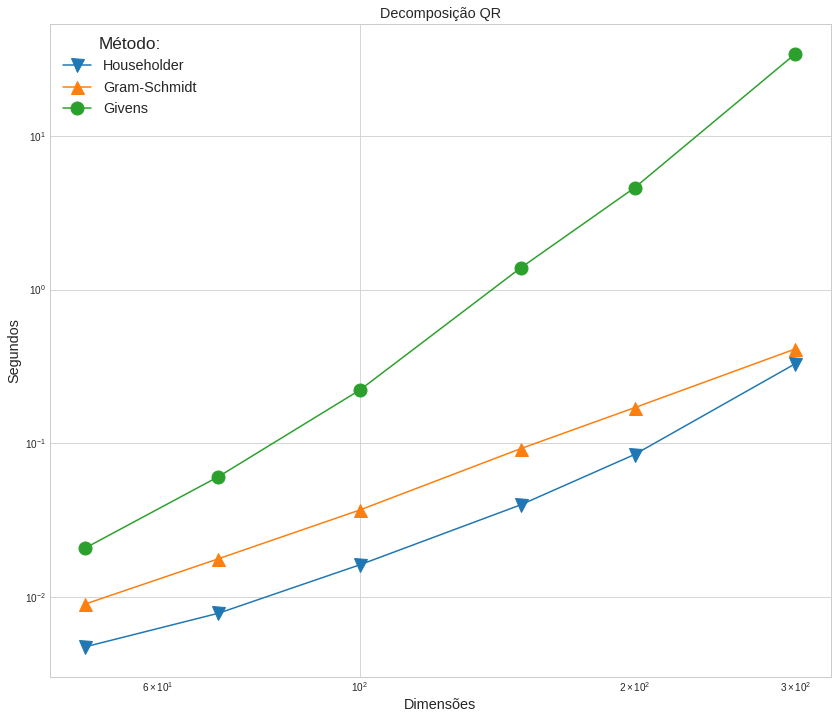

In [54]:
plotar(temposHolder,temposSchmidt,temposGivens,dim,True)

# Regressão Gram-Schmidt

### REGRESSÃO SEM LOG-SCALE 

In [55]:
x = np.array(dim)
A = x[:, np.newaxis]**[0,1]               #Criou uma nova coluna só de 1
A

array([[  1,  50],
       [  1,  70],
       [  1, 100],
       [  1, 150],
       [  1, 200],
       [  1, 300]])

In [56]:
#Achar y = a*x+b
y = np.array(temposSchmidt)
p, res, rnk, s = lstsq(A,y)
p

array([-0.10802248,  0.00159137])

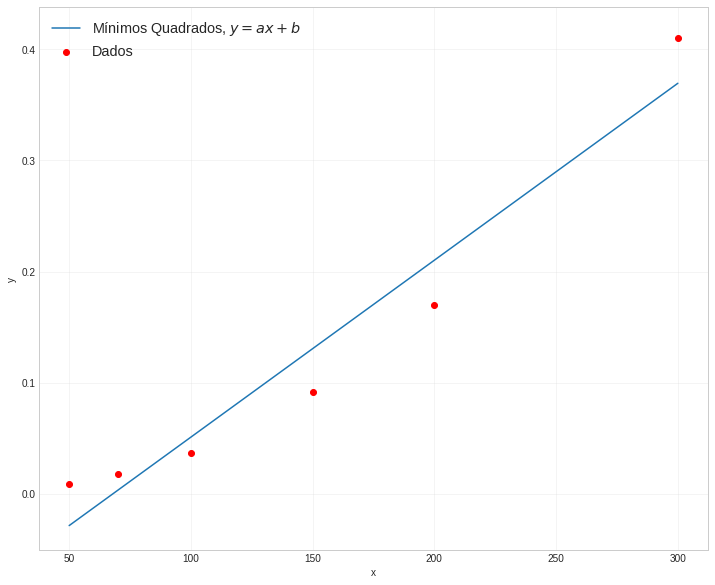

In [57]:
plt.figure(figsize=(12,10))
plt.scatter(x,y,marker= 'o', label='Dados',color='r')

yy = p[0] + (p[1]*x)
plt.plot(x, yy, label='Mínimos Quadrados, $y = ax + b$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(framealpha=1, shadow=True,fontsize='x-large')
plt.grid(alpha=0.25)
plt.show()

### REGRESSÃO COM LOG-SCALE

In [58]:
logX = np.log(x)
logY = np.log(y)

In [59]:
logA = logX[:, np.newaxis]**[0,1]               #Criou uma nova coluna só de 1
logA

array([[1.        , 3.91202301],
       [1.        , 4.24849524],
       [1.        , 4.60517019],
       [1.        , 5.01063529],
       [1.        , 5.29831737],
       [1.        , 5.70378247]])

In [60]:
p, res, rnk, s = lstsq(logA,logY)
p

array([-13.13426456,   2.14428828])

In [61]:
res

0.0032768014914310003

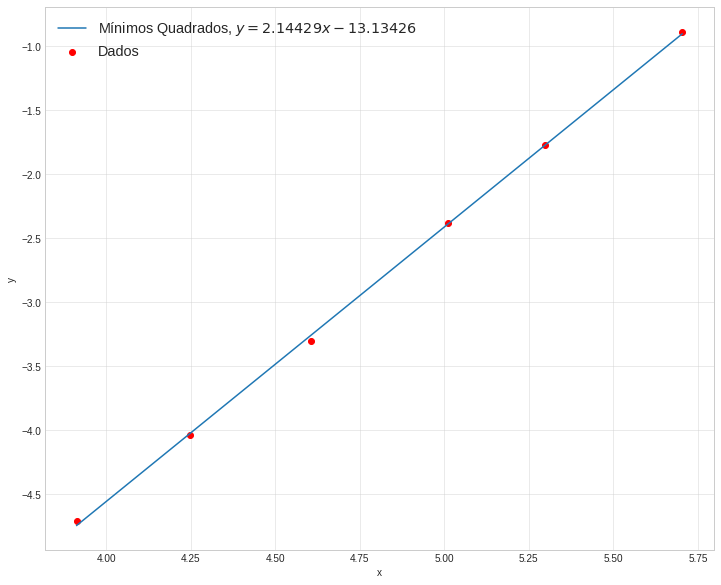

In [62]:
plt.figure(figsize=(12,10))
plt.scatter(logX,logY,marker= 'o', label='Dados',color='r')

yy = p[0] + (p[1]*logX)
plt.plot(logX, yy, label='Mínimos Quadrados, $y = {} x {}$'.format(np.round(p[1],5),np.round(p[0],5)))
plt.xlabel('x')
plt.ylabel('y')
plt.legend(framealpha=0.5, shadow=False,fontsize='x-large')
plt.grid(alpha=0.5)
plt.show()

### Erro quadrático médio - Gram-Schmidt

In [63]:
mean_squared_error(logY,yy)

0.0005461335819052367

# Regressão Rotação de Givens

### REGRESSÃO SEM LOG-SCALE 

In [64]:
x = np.array(dim)
A = x[:, np.newaxis]**[0,1]               #Criou uma nova coluna só de 1
A

array([[  1,  50],
       [  1,  70],
       [  1, 100],
       [  1, 150],
       [  1, 200],
       [  1, 300]])

In [65]:
#Achar y = a*x+b
y = np.array(temposGivens)
p, res, rnk, s = lstsq(A,y)
p

array([-11.62683231,   0.12670896])

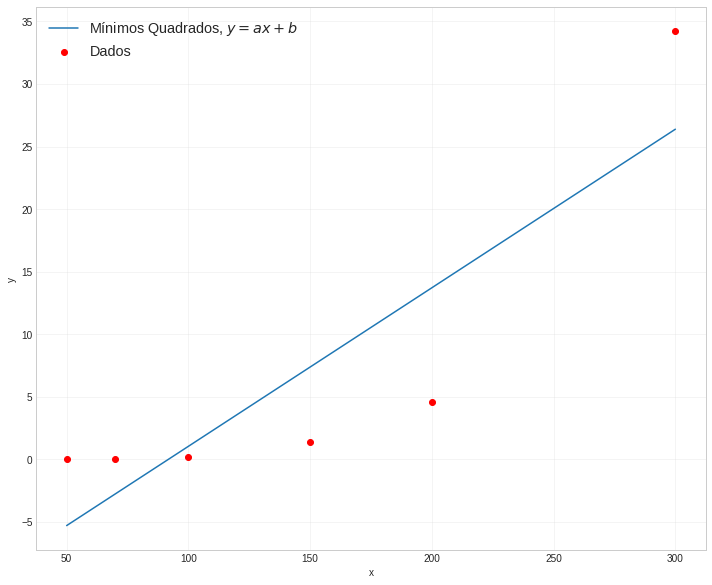

In [66]:
plt.figure(figsize=(12,10))
plt.scatter(x,y,marker= 'o', label='Dados',color='r')

yy = p[0] + (p[1]*x)
plt.plot(x, yy, label='Mínimos Quadrados, $y = ax + b$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(framealpha=1, shadow=True,fontsize='x-large')
plt.grid(alpha=0.25)
plt.show()

### REGRESSÃO COM LOG-SCALE

In [67]:
logX = np.log(x)
logY = np.log(y)

In [68]:
logA = logX[:, np.newaxis]**[0,1]               #Criou uma nova coluna só de 1
logA

array([[1.        , 3.91202301],
       [1.        , 4.24849524],
       [1.        , 4.60517019],
       [1.        , 5.01063529],
       [1.        , 5.29831737],
       [1.        , 5.70378247]])

In [69]:
p, res, rnk, s = lstsq(logA,logY)
p

array([-20.35963104,   4.14734158])

In [70]:
res

0.2057654167226145

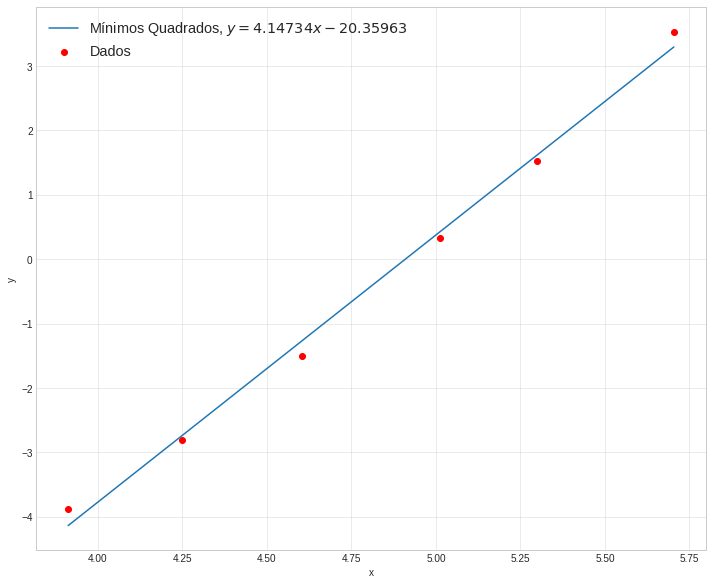

In [71]:
plt.figure(figsize=(12,10))
plt.scatter(logX,logY,marker= 'o', label='Dados',color='r')

yy = p[0] + (p[1]*logX)
plt.plot(logX, yy, label='Mínimos Quadrados, $y = {}x {}$'.format(np.round(p[1],5),np.round(p[0],5)))
plt.xlabel('x')
plt.ylabel('y')
plt.legend(framealpha=0.5, shadow=False,fontsize='x-large')
plt.grid(alpha=0.5)
plt.show()

### Erro quadrático médio - Givens

In [72]:
mean_squared_error(logY,yy)

0.034294236120436604

# Regressão Householder

### REGRESSÃO SEM LOG-SCALE 

In [73]:
x = np.array(dim)
A = x[:, np.newaxis]**[0,1]               #Criou uma nova coluna só de 1
A

array([[  1,  50],
       [  1,  70],
       [  1, 100],
       [  1, 150],
       [  1, 200],
       [  1, 300]])

In [74]:
#Achar y = a*x+b
y = np.array(temposHolder)
p, res, rnk, s = lstsq(A,y)
p

array([-0.09888152,  0.00123563])

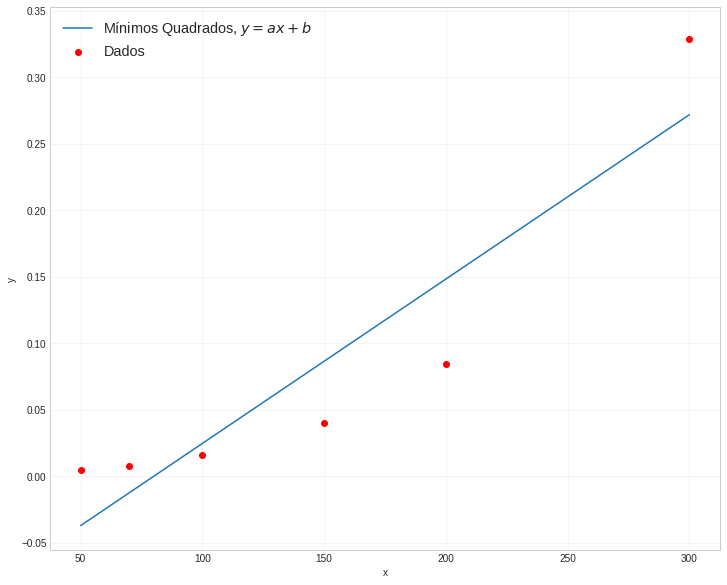

In [75]:
plt.figure(figsize=(12,10))
plt.scatter(x,y,marker= 'o', label='Dados',color='r')

yy = p[0] + (p[1]*x)
plt.plot(x, yy, label='Mínimos Quadrados, $y = ax + b$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(framealpha=1, shadow=True,fontsize='x-large')
plt.grid(alpha=0.25)
plt.show()

### REGRESSÃO COM LOG-SCALE

In [76]:
logX = np.log(x)
logY = np.log(y)

In [77]:
logA = logX[:, np.newaxis]**[0,1]               #Criou uma nova coluna só de 1
logA

array([[1.        , 3.91202301],
       [1.        , 4.24849524],
       [1.        , 4.60517019],
       [1.        , 5.01063529],
       [1.        , 5.29831737],
       [1.        , 5.70378247]])

In [78]:
p, res, rnk, s = lstsq(logA,logY)
p

array([-14.74520092,   2.33959949])

In [79]:
res

0.22286015975583678

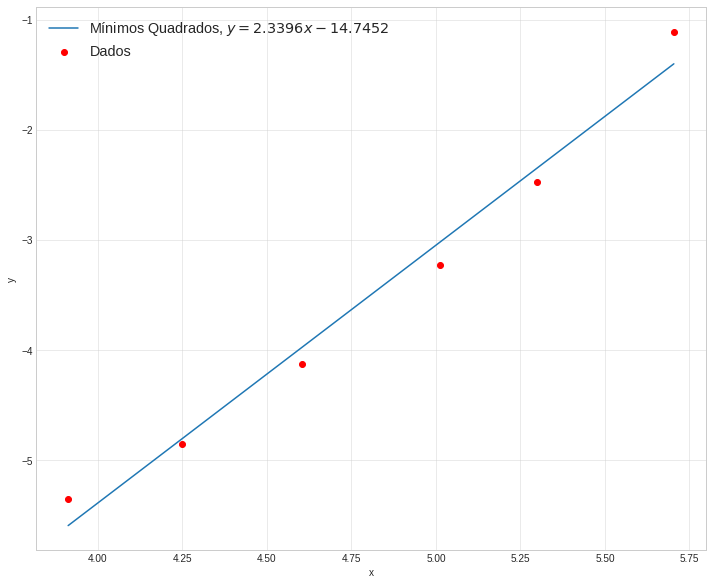

In [80]:
plt.figure(figsize=(12,10))
plt.scatter(logX,logY,marker= 'o', label='Dados',color='r')

yy = p[0] + (p[1]*logX)
plt.plot(logX, yy, label='Mínimos Quadrados, $y = {}x {}$'.format(np.round(p[1],5),np.round(p[0],5)))
plt.xlabel('x')
plt.ylabel('y')
plt.legend(framealpha=0.5, shadow=False,fontsize='x-large')
plt.grid(alpha=0.5)
plt.show()

### Erro quadrático médio - Householder

In [81]:
mean_squared_error(logY,yy)

0.0371433599593067

# Considerações Finais
O processo de Gram–Schmidt é tipicamente instável numericamente. Se por um lado a aplicação das projeções tem um apelo atraente á geométrica para a ortogonalização, a ortogonalização em si é propensa a erros numéricos. Uma grande vantagem, porém, é a facilidade de implementação, o que o torna um algoritmo útil para prototipagem.

As transformações de Householder são a forma simples dos algoritmos de decomposição $QR$, numericamente estáveis devido a forma de produção dos zeros na matriz R. No entanto, o algoritmo de reflexão de Householder tem largura de banda pesada e não é paralelizável, já que cada transformação pode alterar completamente tanto a matriz $Q$ quanto $R$.

A decomposição $QR$ utilizando rotações de Givens é mais complicada de implementar, a ordenação necessária das linhas para explorar plenamente o algoritmo  não é trivial. Ela tem uma vantagem significativa, pois cada novo elemento zero $a_{ij}$ afeta apenas a linha com o elemento a ser zerado e uma linha acima . Isso torna o algoritmo eficiente em largura de banda e paralelizável, diferentemente da técnica de reflexão de Householder.

# FIM 
## Obrigado pela atenção!